In [1]:
# Q-Learning Model Analysis for FullPilot12

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from pybads import BADS
from tqdm.notebook import tqdm

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Starting Q-Learning analysis...")


Starting Q-Learning analysis...


In [2]:
# Q-Learning Model Analysis for FullPilot12
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from pybads import BADS
from tqdm.notebook import tqdm

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Starting Q-Learning analysis...")


Starting Q-Learning analysis...


In [3]:
# Q-Learning Model Implementation

class QLearningModel:
    def __init__(self, learning_rate=0.1, temperature=1.0):
        """
        Simple Q-learning model with temperature and learning rate.
        
        Parameters:
        - learning_rate: Learning rate for Q-value updates
        - temperature: Temperature parameter for softmax choice
        """
        self.learning_rate = learning_rate
        self.temperature = temperature
        
        # Initialize Q-values for each spaceship (280, 380, 500, 620, 720)
        self.spaceships = [280, 380, 620, 720]
        self.q_values = {ship: 0.5 for ship in self.spaceships}  # Initialize to neutral value
        
    def softmax_choice(self, q1, q2):
        """Make choice using softmax with temperature"""
        if self.temperature == 0:
            return 0 if q1 > q2 else 1
        
        exp_q1 = np.exp(q1 * self.temperature)
        exp_q2 = np.exp(q2 * self.temperature)
        prob_choice_1 = exp_q1 / (exp_q1 + exp_q2)
        
        return prob_choice_1
    
    def update_q_value(self, spaceship, reward):
        """Update Q-value using Q-learning rule"""
        current_q = self.q_values[spaceship]
        self.q_values[spaceship] = current_q + self.learning_rate * (reward - current_q)
    
    def get_choice_probability(self, spaceship1, spaceship2, action):
        """Get probability of choosing action (0 or 1) given two spaceships"""
        q1 = self.q_values[spaceship1]
        q2 = self.q_values[spaceship2]
        
        prob_choice_1 = self.softmax_choice(q1, q2)
        
        if action == 0:  # Choose spaceship 1
            return prob_choice_1
        else:  # Choose spaceship 2
            return 1 - prob_choice_1
    
    def simulate_choice(self, spaceship1, spaceship2):
        """Simulate a choice between two spaceships"""
        prob_choice_1 = self.softmax_choice(self.q_values[spaceship1], self.q_values[spaceship2])
        return np.random.choice([0, 1], p=[prob_choice_1, 1 - prob_choice_1])


def fit_qlearning_model(params, data):
    """
    Fit Q-learning model to participant data.
    
    Parameters:
    - params: [learning_rate, temperature]
    - data: tuple of (s, a, r, session, destroy)
    
    Returns:
    - negative log-likelihood
    """
    learning_rate, temperature = params
    s, a, r, session, destroy = data
    
    # Initialize model
    model = QLearningModel(learning_rate=learning_rate, temperature=temperature)
    
    log_likelihood = 0
    
    for t in range(len(s)):
        spaceship1, spaceship2 = s[t]
        action = a[t]
        reward = r[t]
        sess = session[t]
        destroyed = destroy[t]

        
        # Get choice probability
        prob = model.get_choice_probability(spaceship1, spaceship2, action)
        
        # Avoid numerical issues
        prob = np.clip(prob, 1e-10, 1 - 1e-10)
        log_likelihood += np.log(prob)
        assert destroyed == 1
        # Update Q-values only if reward was received (destroyed = 1)
        if destroyed and sess in [0, 2, 3]:  # Value learning sessions
            chosen_spaceship = spaceship1 if action == 0 else spaceship2
            model.update_q_value(chosen_spaceship, reward)
    
    return -log_likelihood, model


print("Q-Learning model implementation complete!")


Q-Learning model implementation complete!


In [4]:

import seaborn as sns
# import sys
# sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('../data/raw/fullpilot13_22.csv')
df2 = pd.read_csv('../data/raw/fullpilot1466.csv')


df2 = df2[df2.expName.isin(['FullPilot14'])]
df = df[df.expName.isin(['FullPilot13', 'FullPilot12'])]

df = df.groupby('prolificID').filter(lambda x: len(x) >= 483)
df2 = df2.groupby('prolificID').filter(lambda x: len(x) >= 483)
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df = df[df.prolificID.str.len() > 10]
df2 = df2[df2.prolificID.str.len() > 10]
# show prolificIDs 

df = pd.concat([df, df2])
df = df[df.expName.isin(['FullPilot12', 'FullPilot13', 'FullPilot14'])]

df = df[df.session.isin([0, 1, 2, 3])]

# Adjust `t` to be cumulative across sessions
# Compute the number of trials in each session
session_counts = df.groupby('session')['t'].max() + 1

# Compute the cumulative starting points for each session
cumulative_starts = session_counts.cumsum().shift(fill_value=0)

# Map each session to its starting point and adjust `t`
df['t'] = df['t'] + df['session'].map(cumulative_starts)

df = df[df.choice.isin([1, 2])]
# df = df[df.pair.isin([0,1])]
df.loc[df.expName=='FullPilot14', 'destroyed'] = 1

df['ev1'] = df.p1 * df.m1
df['ev2'] = df.p2 * df.m2
df['delta_ff'] = (df.p1 - df.p2).abs().round(2)
df['delta_ss'] = (df.m1 - df.m2).abs().round(2)
df['delta_ev'] = (df.ev1 - df.ev2).abs().round(2)
df['opti_ev'] = (df.ev1 >= df.ev2) & (df.choice == 1) | (df.ev2 >= df.ev1) & (df.choice == 2)
df['opti_ff'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
df['opti_ss'] = (df.m1 > df.m2) & (df.choice == 1) | (df.m2 > df.m1) & (df.choice == 2)

df['outcome'] = (df.outcome1 * (df.choice == 1) * df.destroyed) + (df.outcome2 * (df.choice == 2) * df.destroyed)
df['outcome'] /= 1000
# fireTime is in ms, convert to seconds
df['fireTime'] = df.fireTime / 1000
# df['trial'] = ((df.t.max()+1) * (df.session-2)) + df.t
df['trial'] = df.t
df['s'] = list(zip(df.m1, df.m2))

print('Number of participants:', df.prolificID.nunique())
map_prolificID = {pid: i for i, pid in enumerate(df.prolificID.unique())}
df['id'] = df.prolificID.map(map_prolificID)

# df['pair'] = df.pair.apply(lambda x: 0 if x < 0 else x)

# define probabilities
x = np.linspace(-1, 1, 9)
pp = (1/(1+np.exp(-2*x))).round(2)


slope = 2
logistic = lambda x: 1/(1+np.exp(-slope*x))
map_ff_values = {logistic(i).round(2):i for i in np.linspace(-1, 1, 9)}
map_ff_values[1] = 1
df['agent'] = df.prolificID

df['s'] = list(zip(df.m1, df.m2))
df['a'] = (df.choice - 1).astype(int)  # Convert choice to 1 or 0
df['r'] = df.outcome
df['ff1'] = df.p1.map(map_ff_values)
df['ff2'] = df.p2.map(map_ff_values)
# if (df.p1.unique()[0]==1):
    # df['ff1'] = .25
    # df['ff2'] = .25
df['destroy'] = df.destroyed





Number of participants: 190


In [6]:
expName = ["FullPilot13", "FullPilot12"]
session = 3
df_ = df[(df.session==session)].groupby(['prolificID'], as_index=False).mean(numeric_only=True)

import scipy.stats as stats

df_['delta'] = df_.opti_ff - df_.opti_ss

df_['opti_ff'] = df_.opti_ff.astype(float)
df_['opti_ss'] = df_.opti_ss.astype(float)
df_['delta'] = df_.delta.astype(float)
df['opti_ff'] = df['opti_ff'].astype(float)
df['opti_ss'] = df['opti_ss'].astype(float)
         
df2 = df[(df.session==session) & (df.expName.isin(expName))]

def get_group2(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    ttest = stats.ttest_rel(opti_ff, opti_ss)
    p = ttest.pvalue
    t = ttest.statistic
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p > 0.05:
        if p_ss and p_ff:
            return 'balanced'
        if p_ss:
            return 'value'
        if p_ff:
            return 'perceptual'
        return 'random'
    
    if t > 0 and p_ff:
        return 'perceptual'
    if t < 0  and p_ss:
        return 'value'

    return 'random'

def get_group(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p_ss and p_ff:
        return 'combined'
        
    
    if p_ff:
        return 'perceptual'
    if p_ss:
        return 'value'

    return 'random'
    # raise ValueError('unexpected value')

df_['group'] = df_.apply(get_group, axis=1)

df['group'] = df['prolificID'].map(df_.set_index('prolificID')['group'])

# df = df[df.group != 'random']
print(len(df.prolificID.unique()))

c:\Users\garciaba\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\garciaba\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\garciaba\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\numpy\core\fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\garciaba\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\garciaba\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

190


In [33]:
# Fit Q-Learning Model using BADS

def optimize_qlearning_agent(agent, agent_data):
    """Optimize Q-learning model for a single agent"""
    agent_data = agent_data[(agent_data.session == 2)]
                             #((agent_data.session == 3) & (agent_data.pair.isin([0, 1])))]
    # sort
    agent_data = agent_data.sort_values('t')
    # Prepare data
    s = agent_data.s.values
    a = agent_data.a.values
    r = agent_data.r.values
    session = agent_data.session.values
    destroy = agent_data.destroyed.values
    
    # Create data tuple
    data = (s, a, r, session, destroy)
    
    # Define objective function for BADS
    def objective(params):
        neg_ll, _ = fit_qlearning_model(params, data)
        return neg_ll
    
    # Set parameter bounds
    # learning_rate: [0.001, 1.0]
    # temperature: [0.1, 10.0]
    lower_bounds = np.array([0.001, 0.1])
    upper_bounds = np.array([1.0, 10.0])
    x0 = np.array([0.1, 1.0])  # Initial guess
    
    # Initialize BADS
    bads = BADS(
        objective,
        x0=x0,
        lower_bounds=lower_bounds,
        upper_bounds=upper_bounds,
        options={'display': 'off'}
    )
    
    # Optimize
    optimize_result = bads.optimize()
    
    # Get final model with optimal parameters
    _, final_model = fit_qlearning_model(optimize_result.x, data)
    
    return {
        'agent': agent,
        'learning_rate': optimize_result.x[0],
        'temperature': optimize_result.x[1],
        'neg_log_likelihood': optimize_result.fval,
        'final_model': final_model
    }


# Focus on FullPilot12 experiment only
df_pilot12 = df[df.expName == 'FullPilot13'].copy()
agents_pilot12 = df_pilot12.agent.unique()

print(f"Fitting Q-learning model for {len(agents_pilot12)} participants in FullPilot12...")

# Fit models for all participants

# PARALLEL FITTING USING JOBLIB
results = []
for result in Parallel(n_jobs=-2, backend='loky')(
    delayed(optimize_qlearning_agent)(agent, df_pilot12[df_pilot12.agent == agent].sort_values('t')) 
    for agent in tqdm(agents_pilot12)
):
    results.append(result)

# Convert results to DataFrame
fit_results = pd.DataFrame([{
    'agent': r['agent'],
    'learning_rate': r['learning_rate'],
    'temperature': r['temperature'],
    'neg_log_likelihood': r['neg_log_likelihood']
} for r in results])

print("Model fitting complete!")
print(f"Mean learning rate: {fit_results['learning_rate'].mean():.3f}")
print(f"Mean temperature: {fit_results['temperature'].mean():.3f}")
print(f"Mean negative log-likelihood: {fit_results['neg_log_likelihood'].mean():.3f}")


Fitting Q-learning model for 64 participants in FullPilot12...


  0%|          | 0/64 [00:00<?, ?it/s]

Model fitting complete!
Mean learning rate: 0.503
Mean temperature: 7.247
Mean negative log-likelihood: 23.378


In [14]:
df_pid.group

AttributeError: 'DataFrame' object has no attribute 'group'

In [18]:
df_pid

,session,t,pair,choice,outcome1,outcome2,choseLeft,op1IsLeft,moveTime,fireTime,...,id,a,r,ff1,ff2,destroy,agent,learning_rate,temperature,neg_log_likelihood
0,2.095238,157.873016,0.704762,1.314286,602.971429,400.387302,0.536508,0.476190,705.866667,1.017924,...,102.0,0.314286,0.436857,0.288889,0.269048,0.736508,5484d361fdf99b0379939d5b,0.540331,9.999999,20.047178
1,2.095238,157.971429,0.688889,1.409524,604.301587,398.190476,0.492063,0.476190,617.174603,0.738235,...,58.0,0.409524,0.415127,0.287302,0.302381,0.774603,58c42d725866f200017c5deb,0.088074,9.999999,43.033353
2,2.085714,157.025397,0.701587,1.431746,603.390476,397.746032,0.523810,0.504762,281.730159,0.595854,...,70.0,0.431746,0.407190,0.285714,0.307143,0.812698,5a580fb6eedc320001426cd7,0.001000,0.100001,66.544201
3,2.085714,157.200000,0.704762,1.431746,599.949206,397.295238,0.507937,0.584127,859.212698,1.304165,...,7.0,0.431746,0.361695,0.285714,0.346032,0.650794,5a9353586219a30001d2f2af,0.124699,9.999987,37.120195
4,2.088608,157.500000,0.702532,1.427215,600.297468,396.199367,0.512658,0.465190,406.753165,0.611579,...,84.0,0.427215,0.414222,0.288766,0.308544,0.768987,5a9416ba6475f900019fa690,0.999996,9.999987,23.959722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.088608,157.500000,0.702532,1.341772,604.661392,398.756329,0.518987,0.525316,768.702532,0.907215,...,74.0,0.341772,0.457440,0.310127,0.301424,0.784810,66f09b3690fe3df51613a689,0.311491,9.999999,27.955743
57,2.088608,157.500000,0.702532,1.443038,601.303797,399.142405,0.509494,0.490506,573.148734,0.825228,...,1.0,0.443038,0.395152,0.309335,0.284019,0.737342,66f6c4195f17d26ce8c8018d,0.057897,9.999999,49.512529
58,2.095238,157.996825,0.704762,1.495238,602.498413,398.596825,0.539683,0.501587,425.177778,0.799860,...,10.0,0.495238,0.386114,0.295238,0.304762,0.765079,66f7102d3196ce5e60b2c1bd,0.016892,10.000000,62.028313
59,2.088608,157.500000,0.702532,1.503165,601.500000,396.851266,0.591772,0.500000,379.943038,0.914313,...,103.0,0.503165,0.354772,0.276108,0.306962,0.727848,66fc60b6f59bcb7d6dba7d4f,0.001000,0.100001,66.543567


# perceptual vs value strategies in partial reward exp. cannot be explained by lower/higher learning rate in training 

C:\Users\garciaba\AppData\Local\Temp\ipykernel_12976\3601985415.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='group', y='learning_rate', data=df_pid, join=False)
c:\Users\garciaba\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,group,combined,perceptual,False,True,1.204330,33.781364,two-sided,0.236832,0.57,0.369510
1,group,combined,random,False,True,3.212766,26.000000,two-sided,0.003490,11.412,1.178943
2,group,combined,value,False,True,0.862447,23.521282,two-sided,0.397150,0.472,0.324295
3,group,perceptual,random,False,True,1.948999,32.424121,two-sided,0.059991,1.373,0.610456
4,group,perceptual,value,False,True,-0.241849,28.205449,two-sided,0.810647,0.339,-0.078740
5,group,random,value,False,True,-2.050556,24.343276,two-sided,0.051225,1.603,-0.768453


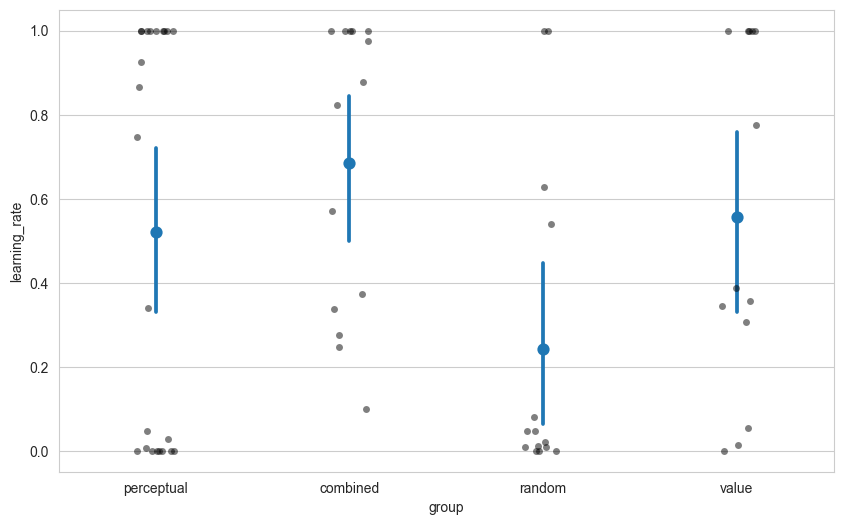

In [35]:
sns.pointplot(x='group', y='learning_rate', data=df_pid, join=False)
sns.stripplot(x='group', y='learning_rate', data=df_pid, color='black', alpha=0.5)

import pingouin as pg
pg.pairwise_ttests(dv='learning_rate', between='group', data=df_pid)

In [34]:
# add fit_results values to df_pid

df_pid = df_pilot12.groupby(['prolificID', 'group'], as_index=False).mean(numeric_only=True)
df_pid = df_pid.merge(fit_results, left_on='prolificID', right_on='agent')

In [64]:
# Extract Q-values at the end of Session 0

def get_session_0_qvalues(agent, df_pilot12, learning_rate, temperature):
    """
    Simulate Q-learning for session 0 only and extract final Q-values
    """
    # Get session 0 data for this agent
    agent_data = df_pilot12[(df_pilot12.agent == agent) & (df_pilot12.session.isin([0, 2]))].sort_values('t')
    
    # Initialize model with fitted parameters
    model = QLearningModel(learning_rate=learning_rate, temperature=temperature)
    
    # Simulate through session 0
    for _, trial in agent_data.iterrows():
        spaceship1, spaceship2 = trial.s
        action = trial.a
        reward = trial.r
        destroyed = trial.destroyed
        
        # Update Q-values if reward was received
        if destroyed:
            chosen_spaceship = spaceship1 if action == 0 else spaceship2
            model.update_q_value(chosen_spaceship, reward)

    return model.q_values


# Extract Q-values at end of session 0 for all participants
session_0_qvalues = []

for result in results:
    agent = result['agent']
    learning_rate = result['learning_rate']
    temperature = result['temperature']
    
    qvalues = get_session_0_qvalues(agent, df_pilot12, learning_rate, temperature)
    
    # Add to results
    for spaceship, qvalue in qvalues.items():
        session_0_qvalues.append({
            'agent': agent,
            'spaceship': spaceship,
            'q_value': qvalue,
            'learning_rate': learning_rate,
            'temperature': temperature
        })

# Convert to DataFrame
qvalues_df = pd.DataFrame(session_0_qvalues)

# Calculate true expected values for spaceships
true_expected_values = {
    280: 0.28,
    380: 0.38,
    620: 0.62,
    720: 0.72
}

# Add true expected values to DataFrame
qvalues_df['true_ev'] = qvalues_df['spaceship'].map(true_expected_values)

print("Q-values extraction complete!")
print(f"Shape of Q-values DataFrame: {qvalues_df.shape}")

# Display summary statistics
print("\nQ-values summary by spaceship:")
summary_stats = qvalues_df.groupby('spaceship').agg({
    'q_value': ['mean', 'std', 'min', 'max'],
    'true_ev': 'first'
}).round(3)
print(summary_stats)


Q-values extraction complete!
Shape of Q-values DataFrame: (244, 6)

Q-values summary by spaceship:
          q_value                      true_ev
             mean    std    min    max   first
spaceship                                     
280         0.365  0.085  0.243  0.497    0.28
380         0.418  0.046  0.351  0.497    0.38
620         0.586  0.047  0.502  0.649    0.62
720         0.657  0.087  0.503  0.749    0.72


Correlation between Q-values and true expected values: 0.866
Mean Absolute Error: 0.060
Root Mean Squared Error: 0.090


C:\Users\basil\AppData\Local\Temp\ipykernel_29480\494831472.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.array(list(true_expected_values.keys()))/1000)


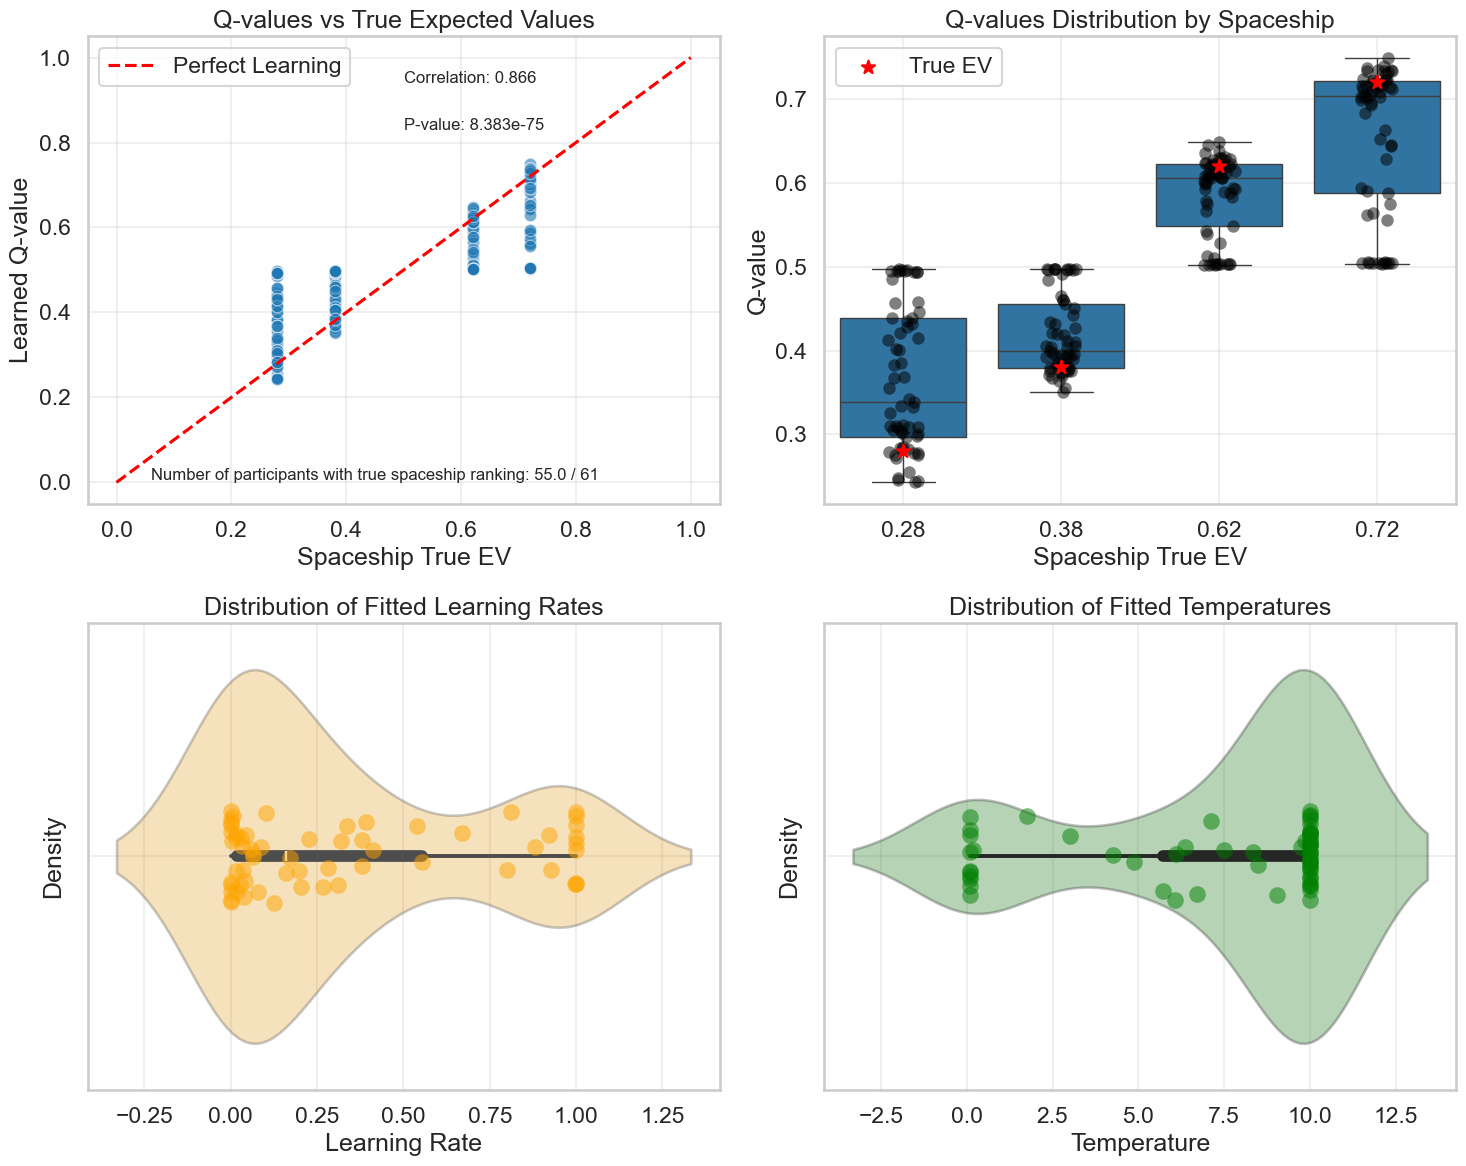


Statistical test:
Pearson correlation: 0.866
P-value: 8.383e-75

Participant-level correlations:
Mean correlation: 0.990
Median correlation: 0.996
Participants with positive correlation: 61/61

SUMMARY: Q-Learning Model Performance
Overall correlation with true values: 0.866
Mean absolute error: 0.060
Root mean squared error: 0.090
Statistical significance: p = 8.383e-75
Mean learning rate: 0.329
Mean temperature: 7.313

✓ Model learned spaceship expected values reasonably well


In [113]:
# Analyze Q-values Learning Performance
# remove where true value = 500 or .5
qvalues_df = qvalues_df[(qvalues_df['true_ev'] != .5) | (qvalues_df['true_ev'] != 500)]
# remove where spaceship = 500
qvalues_df = qvalues_df[qvalues_df['spaceship'] != 500]

# Calculate correlation between learned Q-values and true expected values
correlation = qvalues_df[['q_value', 'true_ev']].corr().iloc[0, 1]
print(f"Correlation between Q-values and true expected values: {correlation:.3f}")

# Calculate mean absolute error
mae = np.mean(np.abs(qvalues_df['q_value'] - qvalues_df['true_ev']))
print(f"Mean Absolute Error: {mae:.3f}")

# Calculate root mean squared error
rmse = np.sqrt(np.mean((qvalues_df['q_value'] - qvalues_df['true_ev'])**2))
print(f"Root Mean Squared Error: {rmse:.3f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.set_context('talk')
# Plot 1: Q-values vs True Expected Values
ax1 = axes[0, 0]
sns.scatterplot(data=qvalues_df, x='true_ev', y='q_value', alpha=0.6, ax=ax1)
# use stripplot instead of scatterplot with jitter
# add poi
ax1.plot([0, 1], [0, 1], 'r--', label='Perfect Learning')
ax1.set_xlabel('Spaceship True EV')
ax1.set_ylabel('Learned Q-value')
ax1.set_title('Q-values vs True Expected Values')
# in the title we also want the number of participants that 
# have the true ranking for spaceship
# such that we need to see that q(spaceship best) > q(spaceship worst)
# and same thing for the other spaceships

for a in qvalues_df['agent'].unique():
    qvalues_df_agent = qvalues_df[qvalues_df['agent'] == a]
    # get the true ranking for spaceship
    true_ranking = qvalues_df_agent.sort_values('true_ev')
    # get the q-values for the spaceships
    q_values = true_ranking['q_value'].values
    # get the true expected values for the spaceships
    # verify that q_values 
    if q_values[0] < q_values[1] and q_values[1] < q_values[2] and q_values[2] < q_values[3]:
        qvalues_df.loc[qvalues_df['agent'] == a, 'true_ranking'] = True
    else:
        qvalues_df.loc[qvalues_df['agent'] == a, 'true_ranking'] = False

# in the title we also want the number of participants that 
# have the true ranking
grouped_qvalues_df = qvalues_df.groupby('agent').true_ranking.last()

# plot text with correlation between q-values and true expected values
ax1.text(0.5, 0.9, f"Correlation: {correlation:.3f}", transform=ax1.transAxes, fontsize=12)
# pvalue
ax1.text(0.5, 0.8, f"P-value: {p_value:.3e}", transform=ax1.transAxes, fontsize=12)

# plot text with the number of participants that have the true ranking for spaceship
ax1.text(0.1, 0.05, f"Number of participants with true spaceship ranking: {grouped_qvalues_df.mean()*61} / 61", transform=ax1.transAxes, fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Q-values by Spaceship
ax2 = axes[0, 1]
sns.boxplot(data=qvalues_df, x='spaceship', y='q_value', ax=ax2)
# Add true expected values as red dots
for spaceship, true_ev in true_expected_values.items():
    ax2.scatter(list(true_expected_values.keys()).index(spaceship), true_ev, 
                color='red', s=100, marker='*', label='True EV' if spaceship == 280 else '', zorder=100)
sns.stripplot(data=qvalues_df, x='spaceship', y='q_value', ax=ax2, alpha=0.5, size=9, color='black')
ax2.set_xlabel('Spaceship True EV')
ax2.set_ylabel('Q-value')
ax2.set_title('Q-values Distribution by Spaceship')
ax2.legend()
ax2.set_xticklabels(np.array(list(true_expected_values.keys()))/1000)
ax2.grid(True, alpha=0.3)


# Plot 3: Learning Rate Distribution
ax3 = axes[1, 0]
# sns.histplot(data=fit_results, x='learning_rate', bins=20, ax=ax3)
# same with boxplot
sns.violinplot(data=fit_results, x='learning_rate', ax=ax3, color='orange', alpha=0.3)
sns.stripplot(data=fit_results, x='learning_rate', ax=ax3, color='orange', alpha=0.5, size=12)
ax3.set_xlabel('Learning Rate')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Fitted Learning Rates')
ax3.grid(True, alpha=0.3)

# Plot 4: Temperature Distribution
ax4 = axes[1, 1]

# same with violinplot
sns.violinplot(data=fit_results, x='temperature', ax=ax4, color='green', alpha=0.3)
sns.stripplot(data=fit_results, x='temperature', ax=ax4, color='green', alpha=0.5, size=12)
# ax4.set_xlim(0, 1)
ax4.set_xlabel('Temperature')
ax4.set_ylabel('Density')
ax4.set_title('Distribution of Fitted Temperatures')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test: Do Q-values significantly correlate with true expected values?
from scipy.stats import pearsonr
correlation_stat, p_value = pearsonr(qvalues_df['q_value'], qvalues_df['true_ev'])
print(f"\nStatistical test:")
print(f"Pearson correlation: {correlation_stat:.3f}")
print(f"P-value: {p_value:.3e}")

# Analysis by individual participants
participant_correlations = []
for agent in qvalues_df['agent'].unique():
    agent_data = qvalues_df[qvalues_df['agent'] == agent]
    if len(agent_data) > 2:  # Need at least 3 points for correlation
        agent_corr = agent_data[['q_value', 'true_ev']].corr().iloc[0, 1]
        participant_correlations.append({
            'agent': agent,
            'correlation': agent_corr
        })

participant_corr_df = pd.DataFrame(participant_correlations)
print(f"\nParticipant-level correlations:")
print(f"Mean correlation: {participant_corr_df['correlation'].mean():.3f}")
print(f"Median correlation: {participant_corr_df['correlation'].median():.3f}")
print(f"Participants with positive correlation: {(participant_corr_df['correlation'] > 0).sum()}/{len(participant_corr_df)}")

# Final summary
print(f"\n{'='*50}")
print("SUMMARY: Q-Learning Model Performance")
print(f"{'='*50}")
print(f"Overall correlation with true values: {correlation:.3f}")
print(f"Mean absolute error: {mae:.3f}")
print(f"Root mean squared error: {rmse:.3f}")
print(f"Statistical significance: p = {p_value:.3e}")
print(f"Mean learning rate: {fit_results['learning_rate'].mean():.3f}")
print(f"Mean temperature: {fit_results['temperature'].mean():.3f}")

if correlation > 0.5:
    print("\n✓ Model learned spaceship expected values reasonably well")
elif correlation > 0.3:
    print("\n~ Model showed moderate learning of spaceship expected values")
else:
    print("\n✗ Model showed poor learning of spaceship expected values")


In [114]:
# also check in a ttest one sample if qvalues for a spaceship
# are statistically different from the true expected value

import scipy.stats as stats

t_data = qvalues_df[['q_value', 'true_ev', 'spaceship']]

# ttest one sample
for spaceship in t_data['spaceship'].unique():
    t_data_spaceship = t_data[t_data['spaceship'] == spaceship]

    # ttest one sample
    ttest = stats.ttest_ind(t_data_spaceship['q_value'], t_data_spaceship['true_ev'])
    print(f"Spaceship {spaceship}: t-statistic = {ttest.statistic:.3f}, p-value = {ttest.pvalue:.3e}")
    # check whether significant
    if ttest.pvalue < 0.05:
        print(f"Spaceship {spaceship} is significantly different from the true expected value")
    else:
        print(f"Spaceship {spaceship} is not significantly different from the true expected value")
    
    # check effect size
    effect_size = ttest.statistic / np.sqrt(len(t_data_spaceship))
    print(f"Spaceship {spaceship}: effect size = {effect_size:.3f}")






Spaceship 280: t-statistic = 7.785, p-value = 2.745e-12
Spaceship 280 is significantly different from the true expected value
Spaceship 280: effect size = 0.997
Spaceship 380: t-statistic = 6.325, p-value = 4.529e-09
Spaceship 380 is significantly different from the true expected value
Spaceship 380: effect size = 0.810
Spaceship 620: t-statistic = -5.673, p-value = 9.880e-08
Spaceship 620 is significantly different from the true expected value
Spaceship 620: effect size = -0.726
Spaceship 720: t-statistic = -5.703, p-value = 8.622e-08
Spaceship 720 is significantly different from the true expected value
Spaceship 720: effect size = -0.730


c:\Users\basil\.pyenv\pyenv-win\versions\3.9.12\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
